# Including temporary employment in the McCall (1970) model

Relative to the baseline model after receiving wage offer $w$, the
worker has three options.

1. accept the offer $w$ for permanent employment,
in which case the worker leaves the labor market and works at wage $w$
forever, 

1. accept the offer $w$ for temporary employment, in which case the
worker works at $w$ only in the current period but rejoins search at the
beginning of next period,

1. reject the offer.

The recursive problem now is

\begin{equation*}
V\left( w\right) =\max_{\left\{ \text{P,T,R}\right\} }\left\{ \frac{%
w}{1-\beta },w+\beta \int_{0}^{B}V\left( w^{\prime }\right) dF\left(
w^{\prime }\right) ,c+\beta \int_{0}^{B}V\left( w^{\prime }\right) dF\left(
w^{\prime }\right) \right\}
\end{equation*}

where P, T, R stand for accept permanent job, accept temporary job, and
reject. The solution to the problem is characterized by two reservation wages $\bar{w}_{P}$ and $\bar{w}_{T}$ above
which the worker accepts permanent and temporary employment, respectively.


Comparing the last two options, clearly $\bar{w}_{T}=c$, temporary
job is preferred if it offers at least $c$. The payoff of the permanent job
and temporary job are both linear and increasing in $w$ but the permanent
job payoff has a higher slope, and they cross exactly once on $\left[ 0,B%
\right] $. Since we already know from the baseline model that the
reservation wage for the permanent job is strictly higher than $c$ due to
the option value of waiting, we have $c=\bar{w}_{T}<\bar{w}_{P}$. When $%
w\leq c=\bar{w}_{T}$, worker rejects the offer, when $w\in \left[ \bar{w}%
_{T},\bar{w}_{P}\right] $, worker accepts temporary employment, and when $%
w\geq \bar{w}_{P}$, worker accepts permanent employment.

As before, denote the value of rejecting the offer

\begin{equation*}
Q=c+\beta \int_{0}^{B}V\left( w^{\prime }\right) dF\left( w^{\prime }\right)
.
\end{equation*}

At $\bar{w}_{P}$, the worker must be indifferent between accepting the
permanent or temporary job.\ Hence

\begin{equation*}
\frac{\bar{w}_{P}}{1-\beta }=\bar{w}_{P}+\beta \int_{0}^{B}V\left( w^{\prime
}\right) dF\left( w^{\prime }\right) =\bar{w}_{P}-c+Q
\end{equation*}

and hence

\begin{equation*}
\bar{w}_{P}=\frac{1-\beta }{\beta }\left( -c+Q\right) .
\end{equation*}

Characterizing $Q$ is therefore equivalent to characterizing $\bar{w}_{P}$.
From the equation for $Q$, we therefore obtain

\begin{equation*}
Q=c+\beta \int_{0}^{B}\max_{\left\{ \text{ P,T,R}\right\} }\left\{
\frac{w^{\prime }}{1-\beta },w^{\prime }-c+Q,Q\right\} dF\left( w^{\prime
}\right) .
\end{equation*}

We can therefore solve the equation for $Q$, for example by successive
approximations. Alternatively, we could have converted this equation into an
equation for $\bar{w}_{P}$ using the same procedure as in the baseline model.

## Numerical implementation

### Successive approximations on $Q$

Solve the baseline model and the modified model.

Define the local folder where graphs will be stored, and from which data will be retrieved. If you are running the notebook within Google Colab, use the second option.

In [1]:
graphfolder = "graphs/"
datafolder = "data/"

# options for Google Colab (uncomment the following lines)
# graphfolder = "gdrive/MyDrive/graphs/"
# datafolder = "gdrive/MyDrive/data/"

Import relevant packages.

In [2]:
# render graphs within notebook
%matplotlib inline

# import packages
import numpy as np
from scipy import stats
import random

# load econutil package with some frequently used functions
import econutil as ec

Root package econutil imported.


In [3]:
# simple_quadrature constructs an equidistant grid quadrature rule on interval r, either from density f or cdf F
# the functions f or F need to be provided as arguments, param is the parameter vector (can be empty)
def simple_quadrature(r=[0,1],I=10,f="",F="",param=""):
    if F:
        # construct weights from F
        nodes = np.linspace(r[0],r[1],I)
        weights = np.linspace(r[0],r[1],I)
        weights[1:-1] = F((nodes[2:]+nodes[1:-1])/2,param) - F((nodes[1:-1]+nodes[:-2])/2,param)
        weights[0] = F((nodes[1]+nodes[0])/2,param) - F(nodes[0],param)
        weights[-1] = F(nodes[-1],param) - F((nodes[-1]+nodes[-2])/2,param)
    elif f:
        nodes = np.linspace(r[0],r[1],I)
        weights = f(nodes,param)
        # nodes at boundaries receive half weight
        weights[0] /= 2
        weights[-1] /= 2
        # renormalize weights to sum up to one
        weights = weights/sum(weights)
    else:
        print('Neither pdf nor cdf were defined.')
            
    return nodes, weights

def reservation_wage_Q_iteration(model):
    Qold,Qnew = 0, model["B"]/(1-model["beta"])/2
    eps = 10**(-10)
    iters = 0
    w_nodes,weights = simple_quadrature(r=[0,model["B"]],I = model["I"],F=model["F_cdf"],param=model["F_param"])
    while abs(Qold-Qnew) > eps:
        Qold = Qnew
        Qnew = model["c"] + model["beta"]*(np.maximum(w_nodes/(1-model["beta"]),Qold)@weights)
        iters += 1
    
    wbar = (1-model["beta"])*Qnew
    return wbar,iters

Successive approximations on the new model

In [4]:
def reservation_wage_temp_job_Q_iteration(model):
    Qold,Qnew = 0, model["B"]/(1-model["beta"])/2
    eps = 10**(-10)
    iters = 0
    w_nodes,weights = simple_quadrature(r=[0,model["B"]],I = model["I"],F=model["F_cdf"],param=model["F_param"])
    while abs(Qold-Qnew) > eps:
        Qold = Qnew
        # update in the value of rejecting an offer: taking into account three options next period
        Qnew = model["c"] + model["beta"]*(np.maximum(np.maximum(w_nodes/(1-model["beta"]),w_nodes-model["c"]+Qold),Qold)@weights)
        iters += 1
    
    wbar_P = (1-model["beta"])/model["beta"]*(-model["c"]+Qnew)
    wbar_T = model["c"]
    return wbar_P,wbar_T,iters

In [5]:
# F is beta cdf on [0,1], with parameters [alpha,beta]
def F_beta(w,param):
    alph = param[0]
    bet = param[1]
    return stats.beta.cdf(w,alph,bet)

# define baseline model parameters, I is the number of random draws of w every period
model = {"beta":0.96, "B": 1, "c": 0.4, "F_cdf": F_beta, "I" : 1000, "F_param": [0.5,0.5]}

# now call the Newton-Raphson routine
wbar,i = reservation_wage_Q_iteration(model)
print(f'Reservation wage in baseline model: {wbar:.5}. Reached in {i} iterations.')
wbar_P,wbar_T,i = reservation_wage_temp_job_Q_iteration(model)
print(f'Reservation wages in extended model: wP={wbar_P:.5}, wT={wbar_T:.5}. Reached in {i} iterations.')

Reservation wage in baseline model: 0.87211. Reached in 78 iterations.
Reservation wages in extended model: wP=0.90648, wT=0.4. Reached in 90 iterations.


### Value function iteration

The baseline model first.

In [6]:
def mccall_value_function_iteration(model):
    I,c,beta = model["I"],model["c"],model["beta"]
    Vnew = np.asmatrix(np.ones([I,1]))
    Vold = np.asmatrix(np.zeros([I,1]))
    w_nodes,weights = simple_quadrature(r=[0,model["B"]],I = model["I"],F=model["F_cdf"],param=model["F_param"])
    w_nodes = np.asmatrix(w_nodes).transpose()
    weights = np.asmatrix(weights).transpose()
    eps = 10**(-10)
    iters = 0
    while max(abs(Vold-Vnew)) > eps:
        Vold = Vnew
        Vnew = np.maximum(w_nodes/(1-beta),c + beta*Vnew.transpose()*weights)
        iters += 1
    # derive reservation wage from Q = wbar/(1-beta)
    wbar = float(((1-model["beta"])*Vnew[0]).item())
    return Vnew,wbar,w_nodes,iters

Modified model.

In [7]:
def mccall_value_function_iteration_temp_job(model):
    I,c,beta = model["I"],model["c"],model["beta"]
    Vnew = np.asmatrix(np.ones([I,1]))
    Vold = np.asmatrix(np.zeros([I,1]))
    w_nodes,weights = simple_quadrature(r=[0,model["B"]],I = model["I"],F=model["F_cdf"],param=model["F_param"])
    w_nodes = np.asmatrix(w_nodes).transpose()
    weights = np.asmatrix(weights).transpose()
    eps = 10**(-10)
    iters = 0
    while max(abs(Vold-Vnew)) > eps:
        Vold = Vnew
        Vnew = np.maximum(np.maximum(w_nodes/(1-beta),w_nodes + beta*Vnew.transpose()*weights), c + beta*Vnew.transpose()*weights)
        iters += 1
    # derive reservation wage from Q = wbar/(1-beta)
    wbar_T = model["c"]
    wbar_P = float(((1-model["beta"])/model["beta"]*(-model["c"]+Vnew[0])).item())
    return Vnew,wbar_P,wbar_T,w_nodes,iters

In [8]:
# solve for the value function using value function iteration
V,wbar,w_nodes,i = mccall_value_function_iteration(model)
print(f'Reservation wage in baseline model: {wbar:.5}. Reached in {i} iterations.')
V_mod,wbar_P,wbar_T,w_nodes_mod,i_mod = mccall_value_function_iteration_temp_job(model)
print(f'Reservation wages in extended model: wP={wbar_P:.5}, wT={wbar_T:.5}. Reached in {i_mod} iterations.')


#wbar,i = reservation_wage_Q_iteration(model)
#print(f'Reservation wage in baseline model: {wbar:.5}. Reached in {i} iterations.')
#wbar_P,wbar_T,i = reservation_wage_temp_job_Q_iteration(model)
#print(f'Reservation wages in extended model: wP={wbar_P:.5}, wT={wbar_T:.5}. Reached in {i} iterations.')


Reservation wage in baseline model: 0.87211. Reached in 80 iterations.
Reservation wages in extended model: wP=0.90648, wT=0.4. Reached in 92 iterations.


Plotting the value functions in the baseline and modified model.


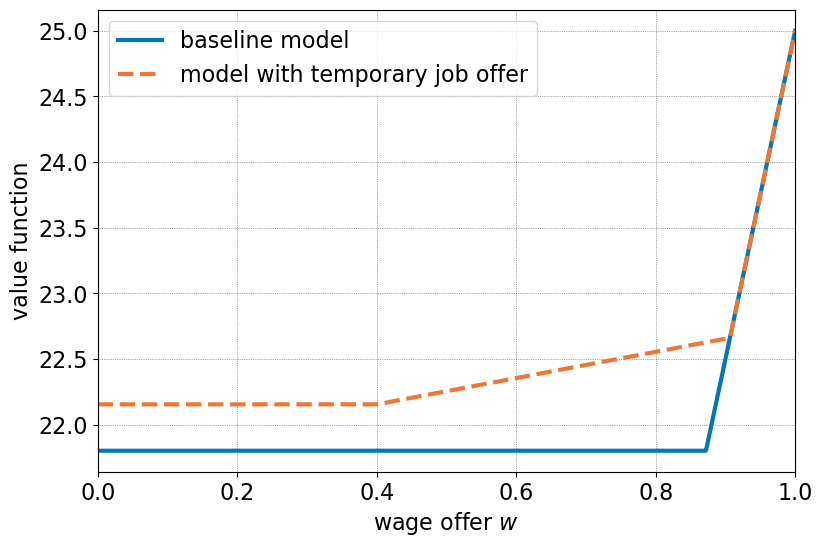

In [9]:
param = {'figsize' : [9,6], 'fontsize': 16, 'subplots': [1,1],
         'title': '',
         'xlim': [0,1], 'ylim': [0,0],
         'xlabel': 'wage offer $w$', 'ylabel': 'value function',
         'ylogscale': False,
         'showgrid': True, 'highlightzero': False,
         'showNBERrecessions' : False, 'showNBERrecessions_y': [0,7]}

print('Plotting the value functions in the baseline and modified model.')
fig,ax = ec.GenerateTSPlot(param)

ax.plot(w_nodes,V,linewidth=3,color=ec.tolColor['tolVibrantBlue'],linestyle='solid',label='baseline model');
ax.plot(w_nodes_mod,V_mod,linewidth=3,color=ec.tolColor['tolVibrantOrange'],linestyle='dashed',label='model with temporary job offer');

x = ax.legend(loc="upper left")

fig.set_facecolor('#FFFFFF')
fig.savefig(graphfolder + 'search_mccall_temporary_job_offer.pdf',bbox_inches='tight')